# Implementing our novel approach with Naive Bayes

> Preprocessing: Clean and preprocess your dataset. This may include handling missing values, encoding categorical variables, and scaling features.

## Load dataset

In [30]:
from libs import data
from libs import kde_lib
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from libs.exp_lib import Density_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
from sklearn.datasets import make_circles, make_moons, make_classification
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import load_iris


def generate_outliers(X,y,outlier_proportion=.1):

    # Define the proportion of outliers to add
    outlier_proportion = outlier_proportion 
    # Calculate the number of outliers to add
    num_outliers = int(outlier_proportion * len(X))
    # Generate random outlier points within the range of the dataset
    outliers_X = np.random.rand(num_outliers, 2) * (np.max(X, axis=0) - np.min(X, axis=0)) + np.min(X, axis=0)
    outliers_y = np.array([1] * num_outliers)  # Assign a class label to outliers

    # Concatenate outliers with the original dataset
    X = np.vstack((X, outliers_X))
    y = np.concatenate((y, outliers_y))
    return X, y

X0, y0 = data.load_data("banana")
#X0, y0 = make_moons(500, noise=.2, random_state=0)
""" X0, y0 = make_classification(
    500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, flip_y=0, class_sep=1.0, random_state=1
)
"""

#X0, y0 = generate_outliers(X0, y0, .2) 
#X0, y0 = make_circles(500, noise=.2, factor=0.5, random_state=0)
""" iris = load_iris()
X0, y0 = generate_outliers(iris.data, iris.target) """
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, random_state=42)

/Users/biad/Desktop/THESIS/Tests/RKDE_HHO/libs/../data/banana/banana
Loaded banana data: 5300 samples, 2 dimensions, 2 labels
classes = {1.0, -1.0}


In [31]:
""" # Get the dimension of our data
dim = X_train.ndim

# Calculate the number of classes and features
classes = np.unique(y_train)
n_features = X_train.shape[1]

# Initialize robust densities
robust_densities = np.zeros((len(X_train), dim))

print(robust_densities.shape)
kernel = 'gaussian'
#h = .5 """


" # Get the dimension of our data\ndim = X_train.ndim\n\n# Calculate the number of classes and features\nclasses = np.unique(y_train)\nn_features = X_train.shape[1]\n\n# Initialize robust densities\nrobust_densities = np.zeros((len(X_train), dim))\n\nprint(robust_densities.shape)\nkernel = 'gaussian'\n#h = .5 "

## Step2 - step3 : Robust Kernel Density Estimation (RKDE) & Bandwidth Selection using HHO:

- Implement the RKDE algorithm with IRLS and Robust M-estimation (Hampel function) for each class.
- Calculate robust densities for each class based on the RKDE algorithm.


In [32]:

""" for class_label in classes:
    # GET for each class
    class_indices = np.where(y_train==class_label)[0]
    class_X = X_train[class_indices]
    h = kde_lib.hho_bandwith_selection(class_X,class_X)
    #h = .5
    # Get for each feature
    rkde_feature =[]
    for d in range(dim):
        X = class_X[:,d] 
        X = X[:,np.newaxis]
        #print(X.shape)
        model = Density_model("rkde", "banana", 0,kernel,h)
        model.fit(X,X,grid=None)
        rkde = model.density
        
        robust_densities[class_indices,d] = rkde[:,0] """

    


' for class_label in classes:\n    # GET for each class\n    class_indices = np.where(y_train==class_label)[0]\n    class_X = X_train[class_indices]\n    h = kde_lib.hho_bandwith_selection(class_X,class_X)\n    #h = .5\n    # Get for each feature\n    rkde_feature =[]\n    for d in range(dim):\n        X = class_X[:,d] \n        X = X[:,np.newaxis]\n        #print(X.shape)\n        model = Density_model("rkde", "banana", 0,kernel,h)\n        model.fit(X,X,grid=None)\n        rkde = model.density\n        \n        robust_densities[class_indices,d] = rkde[:,0] '

## Step4: Incorporating RKDE into Naive Bayes:

> - Modify Naive Bayes classifier to use the RKDE densities instead of traditional Gaussian densities.
> - For prediction, calculate the likelihood using the robust densities obtained from RKDE.

In [33]:
class RobustNaiveBayes(BaseEstimator, ClassifierMixin):

    def __init__(self) -> None:
        self.class_priors = None
        self.classes = None
        #self.robust_densities = None
        self.kernel = 'gaussian'
        self.classifiers = {}  # Store GaussianNB classifiers for each class
        self.robust_densities = {}  # Store robust densities for each class

    
    def fit(self, X, y):
        """
        Fit the robust Naive Bayes model with RKDE densities.

        Parameters:
        X (array-like): Training data features.
        y (array-like): Training data labels.
        """
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate class priors
        self.class_priors = np.array([np.mean(y==c) for c in self.classes])

        # Initialize robust densities
        #robust_densities = np.zeros((n_samples, n_features))
        #robust_densities = np.zeros(n_samples)

        for class_label in self.classes :
            # GET for each class
            class_indices = np.where(y==class_label)[0]
            class_data = X[class_indices]

            self.classifiers[class_label] = GaussianNB()
            self.classifiers[class_label].fit(class_data,y[class_indices])
            """ X_plot = np.linspace(np.min(class_data),np.max(class_data),len(class_data))
            X_plot = X_plot[:,np.newaxis] """
            bandwidth = kde_lib.hho_bandwith_selection(class_data,class_data)
            #bandwidth = .9955
            model = Density_model("rkde","banana",0,self.kernel,bandwidth)
            model.fit(class_data, class_data, grid=None)
            rkde = model.density 

            self.robust_densities[class_label] = rkde[:,0]
            """ self.robust_densities[class_label] = np.zeros((len(class_data),n_features))
            # Get for each feature
            for feature in range(n_features):
                feature_data = class_data[:,feature]
                feature_data = feature_data[:,np.newaxis]
                #bandwidth = .955
                X_plot = np.linspace(np.min(feature_data),np.max(feature_data),len(feature_data))
                X_plot = X_plot[:,np.newaxis] 
                bandwidth = kde_lib.hho_bandwith_selection(feature_data,feature_data)
                #print(feature_data.shape)
                #X_plot = X_plot[:,np.newaxis]
                #print(X_plot.shape)
                model = Density_model("rkde","banana",0,self.kernel,bandwidth)
                model.fit(feature_data, X_plot, grid=None)
                rkde = model.density
                #print(robust_densities[class_indices,feature])
                #robust_densities[class_indices,feature] = rkde[:,0]
                self.robust_densities[class_label][:,feature] = rkde[:,0] """
        #self.robust_densities = np.array(robust_densities)
        """ return self._partial_fit(
            X, y, self.classes, _refit=True, sample_weight=sample_weight
        ) """

        

    def predict(self, X):
        """
        Predict class labels and RKDE likelihoods for input data.

        Parameters:
        X (array-like): Input data features.

        Returns:
        y_pred (array-like): Predicted class labels.
        rkde_likelihoods (array-like): RKDE likelihoods for each class.
        """
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        predictions = []

        """ for sample in X:
            likelihoods = []

            for class_label in self.classes:
                classifier = self.classifiers[class_label]
                robust_density = self.robust_densities[class_label]
                # Calculate the likelihood using the robust density and GaussianNB classifier
                log_likelihood = classifier.predict_joint_log_proba(sample.reshape(1, -1))
                likelihood = np.prod(np.exp(log_likelihood * robust_density)) 
                likelihoods.append(likelihood)

            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.class_priors
            
            predicted_class = np.argmax(normalized_likelihoods)
            predictions.append(self.classes[predicted_class]) """
        for sample in X:

            likelihoods = []

            # Calculate likelihood for each class
            for class_label in self.classes:
                # GET for each class
                #class_indices = np.where(self.y_train == class_label)[0]
                density = self.robust_densities[class_label]
                likelihoods.append(np.prod(norm.pdf(sample, loc=density.mean(), scale=density.std())))
            
            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.class_priors

            # Predict the class with the highest normalized likelihood
            predicted_class = np.argmax(normalized_likelihoods)
            predictions.append(self.classes[predicted_class])
        
        return np.array(predictions)
                


In [34]:
# Create and fit the RobustNaiveBayes classifier
classifier = RobustNaiveBayes()
classifier.fit(X_train, y_train)

normal_NB = GaussianNB()
normal_NB.fit(X_train, y_train)

Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations


2023/08/29 03:42:19 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 43 iterations
Stop at 3 iterations
Stop at 43 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 i

2023/08/29 03:42:41 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 13.39450 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 i

2023/08/29 03:42:55 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 14.13936 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 i

2023/08/29 03:43:09 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 13.45428 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:43:26 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 17.22271 seconds


Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 45 iterations
Stop at 4 iterations
Stop at 45 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 i

2023/08/29 03:43:44 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 18.25351 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 63 iterations
Stop at 6 iterations
Stop at 63 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 i

2023/08/29 03:44:04 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 19.36664 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:44:21 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 17.76002 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:44:36 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 14.89797 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:45:03 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 26.66577 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:45:19 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 16.23775 seconds


Stop at 100 iterations
Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations


2023/08/29 03:45:20 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 79 iterations
Stop at 3 iterations
Stop at 79 iterations
Stop at 1 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 3 ite

2023/08/29 03:45:35 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 7.13261 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:45:50 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 15.60558 seconds


Stop at 92 iterations
Stop at 4 iterations
Stop at 53 iterations
Stop at 4 iterations
Stop at 53 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 21 iterations
Stop at 5 iterations
Stop at 21 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 1 iter

2023/08/29 03:46:05 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 14.66346 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:46:22 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 16.92592 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4

2023/08/29 03:46:42 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 20.18162 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:46:56 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 14.53084 seconds


Stop at 92 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 

2023/08/29 03:47:13 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 16.74409 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:47:31 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 17.40316 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:47:49 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 18.63638 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:48:05 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 15.66742 seconds


Stop at 100 iterations
Result hho_bandwith_selection: [1.]
Stop at 5 iterations
Stop at 100 iterations


GaussianNB()

In [35]:
# Check the shape of our train data and the robust densities
#print(X_train.shape)
#print(classifier.robust_densities.shape)

In [36]:
# Make predictions on the test set
y_pred = classifier.predict(X_test)
print(np.unique(y_pred))

normal_NB_pred = normal_NB.predict(X_test)
print(np.unique(normal_NB_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
print("Accuracy 1:", accuracy)
print("precision 1:", precision)
print("recall 1:", recall)
print("f1 1:", f1)

print("\n")
accuracy = accuracy_score(y_test, normal_NB_pred)
precision = precision_score(y_test, normal_NB_pred)
recall = recall_score(y_test, normal_NB_pred)
f1 = f1_score(y_test, normal_NB_pred )
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1)

# make_moons(500, noise=0.3, random_state=0)

[-1.  1.]
[-1.  1.]
Accuracy 1: 0.70062893081761
precision 1: 0.8823529411764706
recall 1: 0.3508771929824561
f1 1: 0.502092050209205


Accuracy 2: 0.6245283018867924
precision 2: 0.6118251928020566
recall 2: 0.347953216374269
f1 2: 0.4436160298229264


## Classifiers Comparaison 

In [37]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Robust Naive Bayes": RobustNaiveBayes(),
}
X, y = data.load_data("banana")
""" X, y = make_classification(
    500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, flip_y=0, class_sep=1.0, random_state=1
)


X, y = generate_outliers(X, y, .2)
 """
""" rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)  """
linearly_separable = (X, y)

#iris = load_iris()

datasets = [
    #make_moons(3000, noise=0.3, random_state=0),
    #make_circles(500, noise=0.2, factor=0.5, random_state=0),
    linearly_separable,
]
datasets_name = [
    #"make_moons",
   # "make_circles ",
    "make_classification",
]

figure = plt.figure(figsize=(27, 9))
i = 1

/Users/biad/Desktop/THESIS/Tests/RKDE_HHO/libs/../data/banana/banana
Loaded banana data: 5300 samples, 2 dimensions, 2 labels
classes = {1.0, -1.0}


<Figure size 2700x900 with 0 Axes>

Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations


2023/08/29 03:52:09 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 68 iterations
Stop at 3 iterations
Stop at 68 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 i

2023/08/29 03:52:32 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 13.52441 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 ite

2023/08/29 03:52:46 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 14.11204 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 54 iterations
Stop at 4 iterations
Stop at 54 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 i

2023/08/29 03:53:04 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 18.22175 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:53:22 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 17.95588 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:53:44 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 21.25199 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 2 iterations
Stop at 23 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 2 i

2023/08/29 03:54:00 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 16.87662 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:54:26 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 25.36741 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:54:42 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 15.80759 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:55:06 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 24.88592 seconds


Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6

2023/08/29 03:55:27 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 20998.30550052184, Global best: 20998.30550052184, Runtime: 20.43697 seconds


Stop at 100 iterations
Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations


2023/08/29 03:55:28 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 31 iterations
Stop at 5 iterations
Stop at 31 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 i

2023/08/29 03:55:46 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 9.99568 seconds


Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 45 iterations
Stop at 2 iterations
Stop at 45 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 itera

2023/08/29 03:55:56 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 10.82507 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 ite

2023/08/29 03:56:07 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 10.55536 seconds


Stop at 92 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 

2023/08/29 03:56:24 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 16.83224 seconds


Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 i

2023/08/29 03:56:42 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 18.50175 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 1 iterations
Stop at 92 iterations
Stop at 5 i

2023/08/29 03:56:56 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 13.78336 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:57:07 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 10.79365 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:57:24 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 17.26200 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 48 iterations
Stop at 5 iterations
Stop at 48 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 i

2023/08/29 03:57:39 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 15.27702 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/29 03:57:59 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 19231.071941399903, Global best: 19231.071941399903, Runtime: 19.26763 seconds


Stop at 100 iterations
Result hho_bandwith_selection: [1.]
Stop at 5 iterations
Stop at 100 iterations


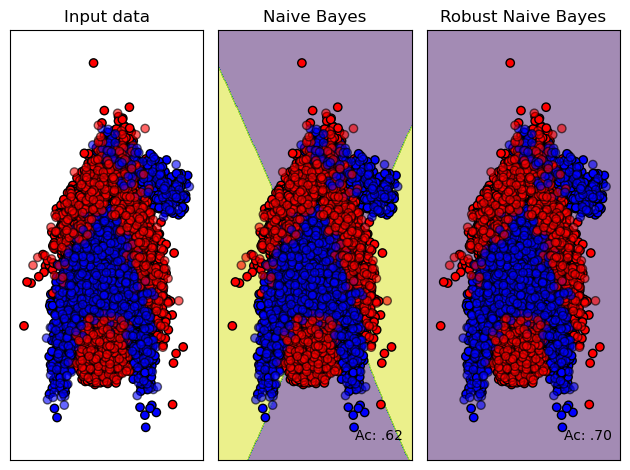

In [38]:
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) +1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in classifiers.items():
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Create a meshgrid for plotting
        h = .02  # Step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        

        #clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)

        # Make predictions using the classifier
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=.5)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        """ DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=.8, ax=ax, eps=.5
        ) """
        
        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("Ac: {}".format(("%.2f" % accuracy).lstrip("0"))),
            size=10,
            horizontalalignment="right",
        )
        i += 1
plt.tight_layout()
plt.show()